# 3D style transfer - 2D to 3D texture
Reference: 
https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/style_transfer_3d.ipynb

https://www.geeksforgeeks.org/image-segmentation-using-pythons-scikit-image-module/

https://realpython.com/image-processing-with-the-python-pillow-library/

https://note.nkmk.me/en/python-pillow-composite/

https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/style_transfer_2d.ipynb

Image/Model Credit to: 
https://colab.research.google.com/drive/1Lvf5BD6ni51AVkdUBIulJlC9-EXD9PKk?authuser=2#scrollTo=tTm0cVuOjb1W

https://freerangestock.com/photos/134372/yellow-flowers--painting-.html

https://unsplash.com/photos/T0jDumk_gpg

https://unsplash.com/photos/FwEPJvzFnWQ




In [ ]:
!pip install -q lucid>=0.2.3

!pip uninstall tensorflow-gpu

!pip install tensorflow-gpu==1.15

# Need to restart runtime after installation!

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 411.5 MB 8.3 kB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
     |████████████████████████████████| 503 kB 36.6 MB/s 
     |████████████████████████████████| 3.8 MB 32.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=63e401f0162585182823638c05abf56b39497ce51ba42dfaf23f1af9d45986ee
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b

In [ ]:
import os
import io
import sys
from string import Template
from pathlib import Path

from PIL import Image, ImageOps, ImageFilter

import matplotlib.pyplot as plt
from matplotlib import cm

from google.colab import files

import numpy as np
import tensorflow as tf

from IPython.display import clear_output, display, HTML

import ctypes.util
from lucid.misc.gl.glcontext import create_opengl_context
import OpenGL.GL as gl

from lucid.misc.gl import meshutil
from lucid.misc.gl import glrenderer

import lucid.misc.io as lucid_io
from lucid.misc.io import show, load, save
import lucid.misc.io.showing as showing
from lucid.misc.tfutil import create_session

from lucid.optvis.param.spatial import sample_bilinear

from lucid.modelzoo import vision_models

import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
from lucid.optvis.style import StyleLoss, mean_l1_loss, gram_style
import lucid.optvis.render as render

"""
We will be writing a custom objective for style transfer, so let's grab this handy
decorator that allows us to take a simple function and mark it as an objective in lucid:

"""
from lucid.optvis.objectives import wrap_objective

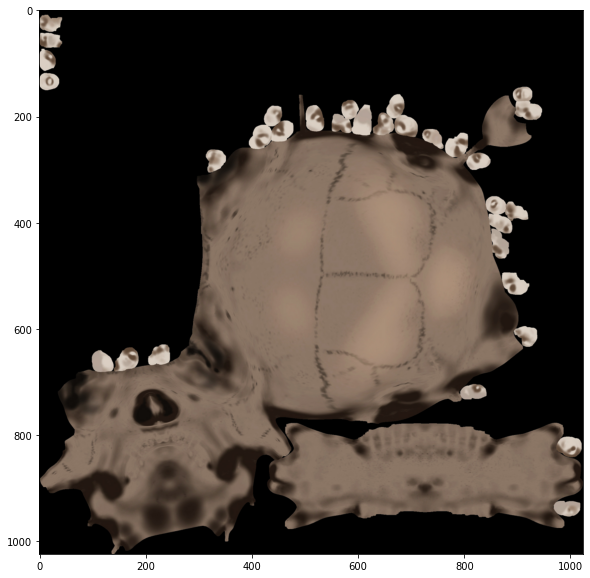

In [ ]:
# loading the original texture of the model and resizing it to 1024x1024
filename_skull = "skull.jpg"

with Image.open(filename_skull) as img_skull:
  img_skull.load()

img_skull = img_skull.resize((1024, 1024))

plt.figure(figsize=(10, 10))
plt.imshow(img_skull)

In [ ]:
def prepare_image(fn, size=None):
  """ 
  fn: image url
  size: specify size if need to resize the image; default: None
  return: a normalized numpy array of single precision float version of the image

  read the image using the url provided
  PIL =  Python Imaging Library :opening, manipulating, and saving many different
  image file formats. Use it to convert to RGB image. 
  """
  data = lucid_io.reading.read(fn)  
  im = Image.open(io.BytesIO(data)).convert('RGB')

  if size:  # resize if size specified
    im = im.resize(size,Image.ANTIALIAS) 
  return np.float32(im)/255.0 
  
  # returns an array of float 32 bits. 
  # So dividing all the values by 255 (since RGB) will convert it
  # to range from 0 to 1. "Normalizing it" makes the image looks better for the
  # visualizer and make computation efficient

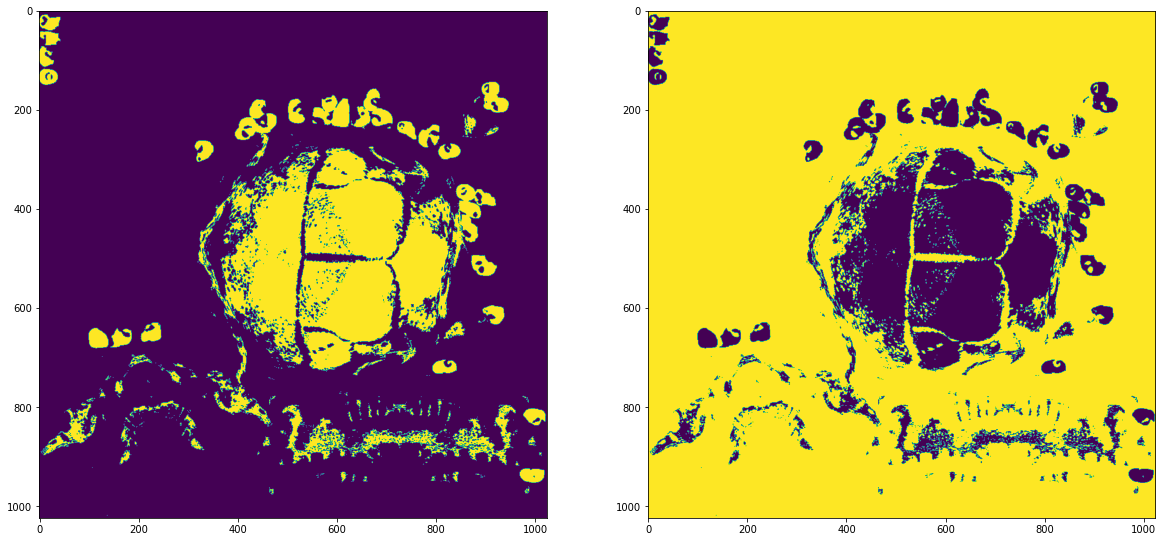

In [ ]:
# split image into RGB components
red, green, blue = img_skull.split() 

threshold = 100 # can be changed depending desired result

# blue channel has highest contrast 
# use this to apply treshold to generate masks
img_skull_threshold = blue.point(lambda x: 255 if x > threshold else 0)

plt.figure(figsize=(20, 20))


# generating a mask and invert it to generate another
skull_msk1 = img_skull_threshold.convert('L')
plt.subplot(1, 2, 1)
plt.imshow(skull_msk1)

skull_msk2 = ImageOps.invert(skull_msk1) # inverse of the mask above
plt.subplot(1, 2, 2)
plt.imshow(skull_msk2)

skull_msk1.save('skull_msk1.png', 'png')
skull_msk2.save('skull_msk2.png', 'png')

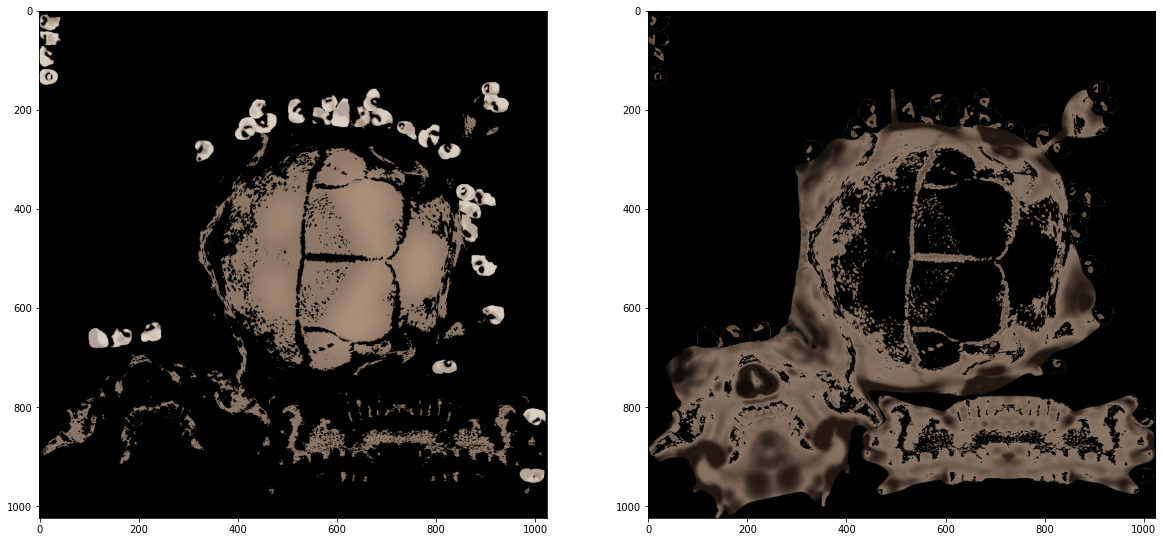

In [ ]:
# blank img same size as img_skull 
blank_img1 = img_skull.point(lambda _: 0)

# apply each mask to the original texture to genrate two parts

skull_msk1 = skull_msk1.convert("L")

skullp1 = Image.composite(img_skull, blank_img1, skull_msk1)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(skullp1)

skullp1.save("skullp1.jpeg", "jpeg")

# blank img same size as img_skull 
blank_img2 = img_skull.point(lambda _: 0)

skull_msk2 = skull_msk2.convert("L")

skullp2 = Image.composite(img_skull, blank_img2, skull_msk2)

plt.subplot(1, 2, 2)
plt.imshow(skullp2)

skullp2.save("skullp2.jpeg", "jpeg")

TRY TO USE GOOGLENET TO DO STYLE TRANSFER INDIVIDUALLY ON EACH IMAGE SEGMENT AND COMBINE

The GoogLeNet architecture consists of 22 layers (27 layers including pooling layers), and part of these layers are a total of 9 inception modules(figure4).
The table below depicts the conventional GoogLeNet architecture. Have a quick review of the table before reading more on the table’s characteristics and features. 

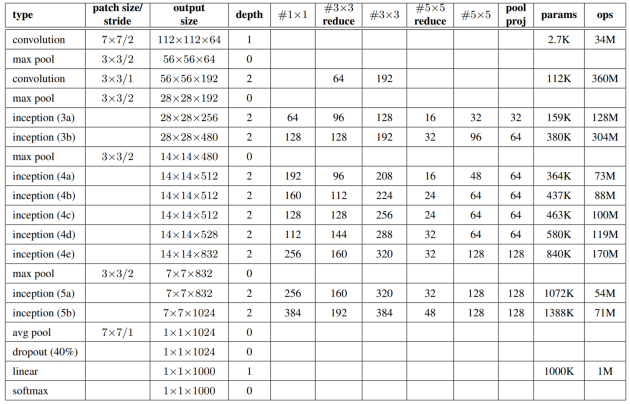

#Characteristics and features of GoogLeNet configuration table (figure 1)

* The input layer of the GoogLeNet architecture takes in an image of the dimension 224 x 224.

* Type: This refers to the name of the current layer of the component within the architecture

* Patch Size: Refers to the size of the sweeping window utilised across conv and pooling layers. Sweeping windows have equal height and width.

* Stride: Defines the amount of shift the filter/sliding window takes over the input image.

* Output Size: The resulting output dimensions(height, width, number of feature maps) of the current architecture component after the input is passed through the layer.

* Depth: Refer to the number of levels/layers within an architecture component.

* 1x1 3x3 5x5: Refers to the various convolutions filters used within the inception module.

* 3X3 reduce 5x5 reduce: Refers to the numbers of 1x1 filters used before the convolutions.

* Pool Proj: This is the number of 1x1 filters used after pooling within an inception module.

* Params: Refers to the number of weights within the current architecture component.

* Ops: Refers to the number of mathematical operations carried out within the component.





In [ ]:
# model is neural network model
model = vision_models.InceptionV1() # initalizing the model
# GoogLeNet or Inception v1 is a convolutional neural network (CNN) which is 27 layers deep.
model.load_graphdef() # loading the model

In [ ]:
# test if GPU is available
tf.test.is_gpu_available()

True

In [ ]:
# skullp1 
content_image1 = load("skullp1.jpeg")
style_url1 = 'bloom.jpg'  
style_image1 = prepare_image(style_url1,size = (1024,1024)) # loading the style reference image 1

# skullp2
content_image2 = load("skullp2.jpeg")
style_url2 = 'green.jpg'
style_image2 = prepare_image(style_url2,size = (1024,1024)) # loading the style reference image 2

# Plotting Figures 
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.imshow(content_image1)

plt.subplot(2, 2, 2)
plt.imshow(style_image1)

plt.subplot(2, 2, 3)
plt.imshow(content_image2)

plt.subplot(2, 2, 4)
plt.imshow(style_image2)

In [ ]:
# List of tensors that are used to compute statistics that define a style.
# each item refers to a specific tensor 

style_layers = [
  'conv2d2',
  'mixed3a',
  'mixed4a',
  'mixed4b',
  'mixed4c',
]

content_layers = [
  'mixed3b',
]

In [ ]:
def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
  style_transfer_input = param.image(*content_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
  content_input = content_image
  style_input = tf.random_crop(style_image, content_image.shape)
  return tf.stack([style_transfer_input, content_input, style_input])

# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2

In [ ]:
style_transfer_param(content_image1, style_image1).shape

style_transfer_param(content_image2, style_image2).shape

TensorShape([Dimension(3), Dimension(1024), Dimension(1024), Dimension(3)])

In [ ]:
@wrap_objective()
def activation_difference(layer_names, activation_loss_f=mean_l1_loss, transform_f=None, difference_to=CONTENT_INDEX):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]

    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]

    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses)

  return inner

In [ ]:
param_f1 = lambda: style_transfer_param(content_image1, style_image1)

content_obj1 = 100 * activation_difference(content_layers, difference_to=CONTENT_INDEX)
content_obj1.description = "Content Loss"

style_obj1 = activation_difference(style_layers, transform_f=gram_style, difference_to=STYLE_INDEX)
style_obj1.description = "Style Loss"

objective1 = - content_obj1 - style_obj1

vis1 = render.render_vis(model, objective1, param_f=param_f1, thresholds=[512], verbose=False, print_objectives=[content_obj1, style_obj1])[-1]

################################################################################

param_f2 = lambda: style_transfer_param(content_image2, style_image2)

content_obj2 = 100 * activation_difference(content_layers, difference_to=CONTENT_INDEX)
content_obj2.description = "Content Loss"

style_obj2 = activation_difference(style_layers, transform_f=gram_style, difference_to=STYLE_INDEX)
style_obj2.description = "Style Loss"

objective2 = - content_obj2 - style_obj2

vis2 = render.render_vis(model, objective2, param_f=param_f2, thresholds=[512], verbose=False, print_objectives=[content_obj2, style_obj2])[-1]


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


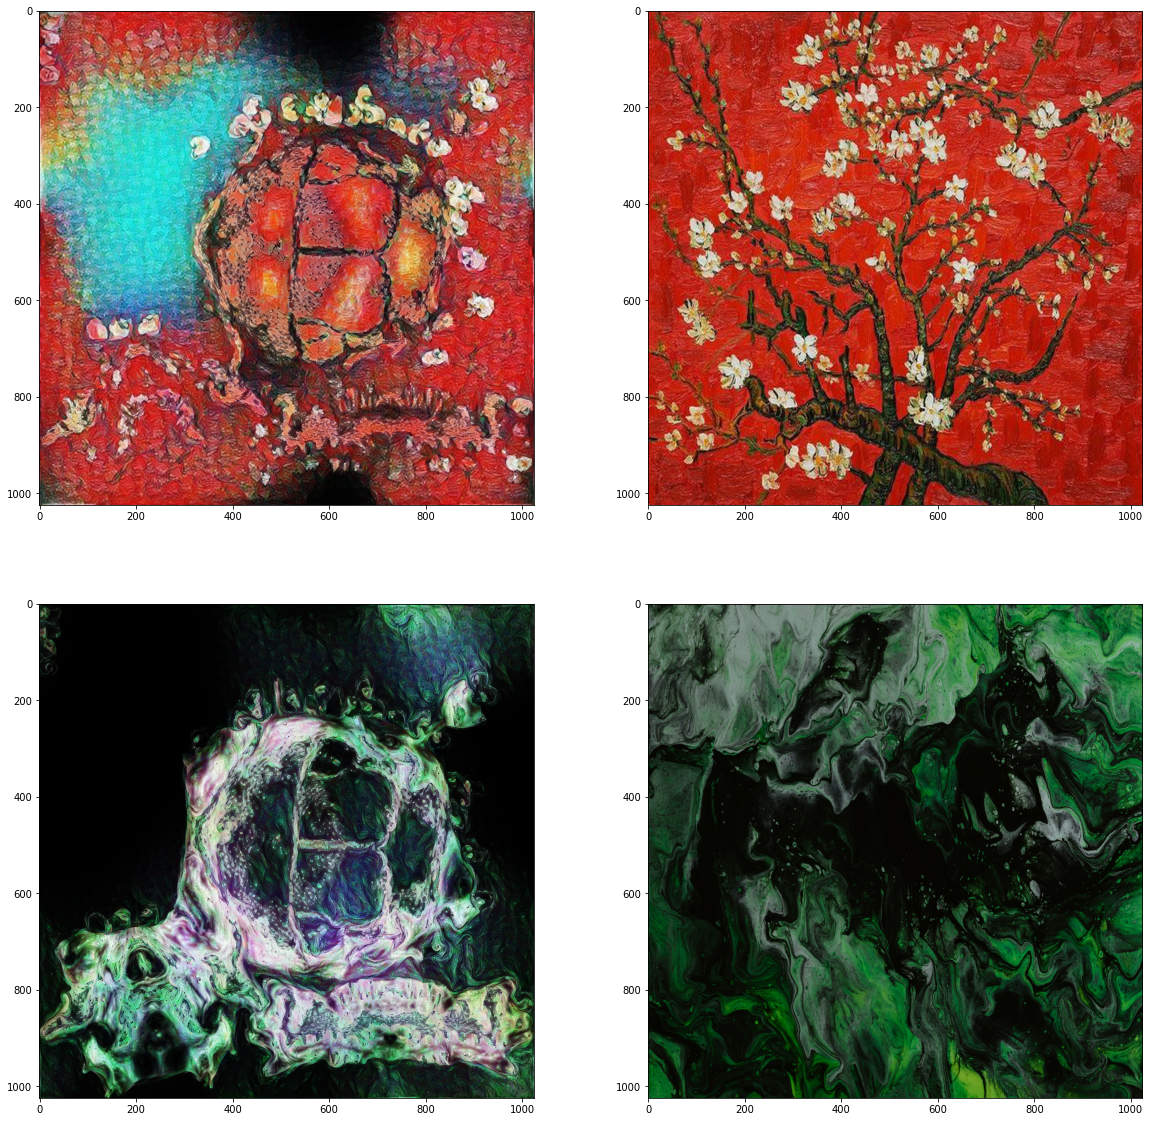

In [ ]:
# Plotting Figures 
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.imshow(vis1[0])

plt.subplot(2, 2, 2)
plt.imshow(style_image1)

plt.subplot(2, 2, 3)
plt.imshow(vis2[0])

plt.subplot(2, 2, 4)
plt.imshow(style_image2)

In [ ]:
img1 = Image.fromarray((vis1[0] * 255).astype(np.uint8))
img1.save("visp1.png") 

img2 = Image.fromarray((vis2[0] * 255).astype(np.uint8))
img2.save("visp2.png") 

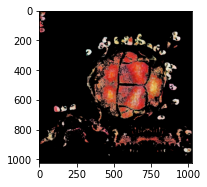

In [ ]:
# blank img same size as img_skull 
blank_img1 = img_skull.point(lambda _: 0)

stylized_p = Image.composite(img1, blank_img1, skull_msk1)
stylized_p.save("stylized_p.png")

plt.subplot(1, 2, 2)
plt.imshow(stylized_p)

In [ ]:
overlay = Image.open("stylized_p.png")
background = Image.open("visp2.png")

# The boundaries can be composited smoothly by blurring the mask image with ImageFilter.
# applying gausian Blur

mask_blur = skull_msk1.filter(ImageFilter.GaussianBlur(10)) 
mask_blur = mask_blur.filter(ImageFilter.SMOOTH_MORE())

final_sylizized = Image.composite(overlay, background, mask_blur)

final_sylizized.save("final.png", "png")

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(mask_blur)

plt.subplot(1, 2, 2)
plt.imshow(final_sylizized)

UV map the texture onto the 3D object and save the new stylized 3D object

In [ ]:
mesh = meshutil.load_obj('skull.OBJ') # Loads 3d mesh form .obj' file
mesh = meshutil.normalize_mesh(mesh)  # Scale mesh to fit into -1..1 cube
new_tex = load('final.png')

In [ ]:
create_opengl_context()
gl.glGetString(gl.GL_VERSION)

renderer = glrenderer.MeshRenderer((512, 512)) # creating an instance of a Meshrenderer Object of size 512x512

In [ ]:
sess = create_session()

# t_fragments is used to feed rasterized UV coordinates for the current view.
# Channels: [U, V, _, Alpha]. Alpha is 1 for pixels covered by the object, and
# 0 for background.
t_fragments = tf.placeholder(tf.float32, [None, None, 4])
t_uv = t_fragments[...,:2]
t_alpha = t_fragments[...,3:]

t_texture = param.image(1024, fft=True, decorrelate=True)[0]
t_frame = sample_bilinear(t_texture, t_uv) * t_alpha

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
model.import_graph(t_frame)

<function lucid.modelzoo.vision_base.Model.import_graph.<locals>.T>


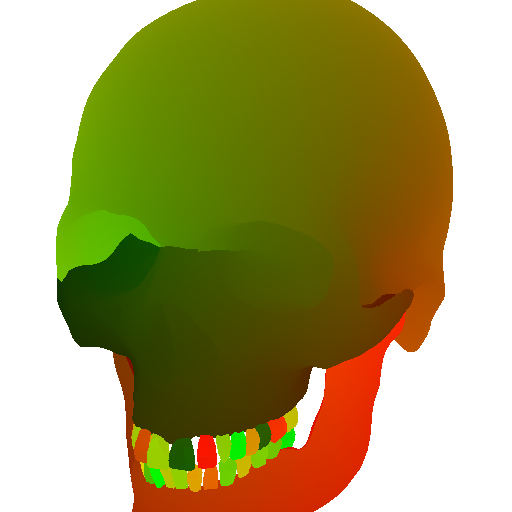
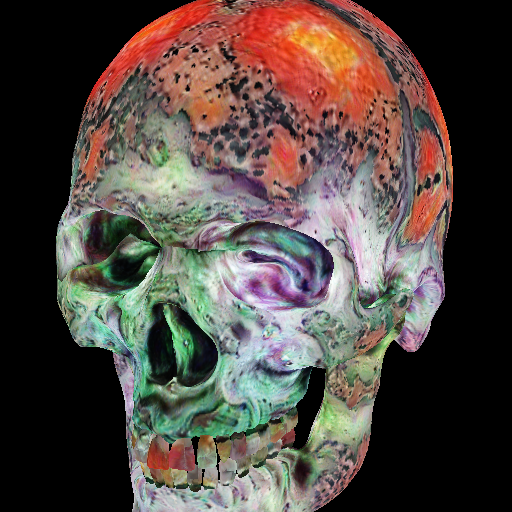

In [ ]:
mesh.pop('normal', None)

fragments = renderer.render_mesh(modelview=meshutil.sample_view(11.0, 11.0), **mesh)
img = t_frame.eval({t_fragments: fragments, t_texture: new_tex})
showing.images([fragments, img])